In [1]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import os

sns.set_context('notebook')
sns.set_style('white')

In [3]:
!pip install kagglehub 
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Resuming download from 61865984 bytes (2401499451 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/paultimothymooney/chest-xray-pneumonia?dataset_version_number=2 (61865984/2463365435) bytes left.


  5%|▌         | 124M/2.29G [04:27<2:32:43, 255kB/s] 


KeyboardInterrupt: 

In [5]:
# Define paths (Change these to match your folder structure)
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

# 1. Preprocessing and Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values to 0-1
    rotation_range=20,     # Random rotation
    zoom_range=0.2,        # Random zoom
    shear_range=0.2,       # Random shear
    horizontal_flip=True   # Random flip
)

# 2. Only Rescaling for Validation/Test (No augmentation here!)
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # Resize images
    batch_size=32,
    class_mode='binary'     # Binary because we have Healthy vs. Diseased
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import VGG16

# 1. Load the pre-trained base model
conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

# 2. Freeze the base
conv_base.trainable = False 

# 3. Build the final model
model = models.Sequential()
model.add(conv_base)                        # The pre-trained part
model.add(layers.Flatten())                 # Flatten 3D map to 1D vector
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dropout(0.5))              # Prevents overfitting
model.add(layers.Dense(1, activation='sigmoid')) # Output layer (1 neuron for binary)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Adjust based on dataset size
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7531 - loss: 0.5097 - val_accuracy: 0.6250 - val_loss: 0.6094
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 936ms/step - accuracy: 0.8636 - loss: 0.3149 - val_accuracy: 0.6875 - val_loss: 0.5171
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8938 - loss: 0.2609 - val_accuracy: 0.8125 - val_loss: 0.4068
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 856ms/step - accuracy: 0.9102 - loss: 0.2278 - val_accuracy: 0.8125 - val_loss: 0.3862
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9150 - loss: 0.2155 - val_accuracy: 0.8125 - val_loss: 0.4645
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 785ms/step - accuracy: 0.9236 - loss: 0.2026 - val_accuracy: 0.7500 - val_loss: 0.5018
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9281 - loss: 0.1924 - val_accuracy: 0.8125 - val_loss: 0.4554
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 777ms/step - accuracy: 0.9256 - loss: 0.1873 - 

In [8]:
conv_base.trainable = True

# Freeze all layers EXCEPT the last block (Block 5)
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


# Recompile with a VERY low learning rate to avoid destroying learned weights
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5), 
              metrics=['accuracy'])

# Train again
history_fine = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9328 - loss: 0.1646 - val_accuracy: 0.7500 - val_loss: 0.5230
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 926ms/step - accuracy: 0.9494 - loss: 0.1426 - val_accuracy: 0.8750 - val_loss: 0.3532
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9456 - loss: 0.1337 - val_accuracy: 0.8125 - val_loss: 0.4659
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 919ms/step - accuracy: 0.9524 - loss: 0.1286 - val_accuracy: 0.7500 - val_loss: 0.6574
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9519 - loss: 0.1223 - val_accuracy: 0.8125 - val_loss: 0.3206
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 982ms/step - accuracy: 0.9598 - loss: 0.1107 - val_accuracy: 0.7500 - val_loss: 0.5309
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9594 - loss: 0.1101 - val_accuracy: 0.6875 - val_loss: 0.6872
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 826ms/step - accuracy: 0.9549 - loss: 0.1219 - 

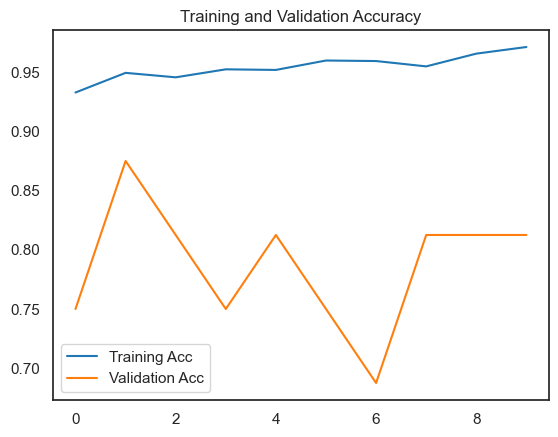

Found 624 images belonging to 2 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 955ms/step - accuracy: 0.9183 - loss: 0.2224
Test Accuracy: 0.92


In [9]:
# Plot accuracy
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Final Test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")